[kaggle](https://www.kaggle.com/competitions/eso-battery-forecasting)
# Summary
## Goal

To predict battery behaviour on Great Britain's electricity network. 

Identify trends, detect anomalies, and develop predictive models to balance the system.

## Editor's Notes
### Iteration 1.
I have added the average by the hour to see the score.
Also, for splitting train|test, I went with using the 2 years worth
of data namely, from 2020-08-01 to 2022-08-31, as my training date.
And the rest are test data.
I did not do any validation yet.
I need to understand first how a battery works in a grid.
I know that the cities must be using it only when there is
no wind, solar and other renewables generating power.
From the averages, I see that the batteries are being charged during early morning.
Then they are being used heavily at night, just before 2000 utc.
What would be interesting is to see how wind|solar are generating energy
and how the price





- Iteration should only be when you make a submission and not for taking notes.
- You need to make note taking effortless. Don't worry too much on formatting.
- Do not get stuck on taking notes. Make it brief and keep coding.

The data seems to be organized by cities
and there is an overarching metric, which is the target - battery_output.
What I understand, battery output is positive when it is recharging
and it is negative when it is discharging.
I need to graph it out so that I can see it and take it from there.






































In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
sns.set_style('whitegrid')

In [145]:
df = pd.read_csv('/kaggle/input/eso-battery-forecasting/train_data.csv')

In [146]:
df.dtypes.value_counts()

float64    262
object      31
int64        1
dtype: int64

In [147]:
df.columns = df.columns.str.lower().str.replace(' ', '')

In [148]:
df['utc_settlement_datetime'] = pd.to_datetime(df['utc_settlement_datetime'])
df['date'] = df['utc_settlement_datetime'].dt.date

In [149]:
num = [x for x in df.columns if df.dtypes[x] == 'float64']
cat = [x for x in df.columns if df.dtypes[x] == 'object']
target = 'battery_output'
num.remove(target)

In [150]:
train = df.loc[df[date].dt.date < pd.Timestamp('2022-09-01').date()]
test = df.loc[df[date].dt.date >= pd.Timestamp('2022-09-01').date()]

# Work Area

In [151]:
corr = train.corr(numeric_only=True)

corr[target].sort_values(ascending=False).head()

battery_output                             1.000000
windspeed_100mnewcastleupontyne_weather    0.036603
windgusts_10mnewcastleupontyne_weather     0.036383
windspeed_10mnewcastleupontyne_weather     0.035655
windspeed_100mleeds_weather                0.031763
Name: battery_output, dtype: float64

In [152]:
price = [x for x in num if 'price' in x]
coor = [x for x in num if 'long' in x or 'latitude' in x]
pop = [x for x in num if 'population' in x]
is_ = [x for x in num if 'is_' in x]

date = 'utc_settlement_datetime'
utco = [x for x in num if 'utc' in x]
surf = [x for x in num if 'surface_pressure' in x]
gent = [x for x in num if 'generationtime' in x]

wcode = [x for x in num if 'weathercode' in x]
temp = [x for x in num if 'temperature' in x]
wind = [x for x in num if 'wind' in x]
cloud = [x for x in num if 'cloud' in x]
rain = [x for x in num if 'prec' in x or 'rain' in x]
humid = [x for x in num if 'humid' in x]
snow = [x for x in num if 'snow' in x]
dewp = [x for x in num if 'dewpoint' in x]
elev = [x for x in num if 'elevation' in x]


In [153]:
belfast = [x for x in df.columns if 'belfast' in x]

## Target

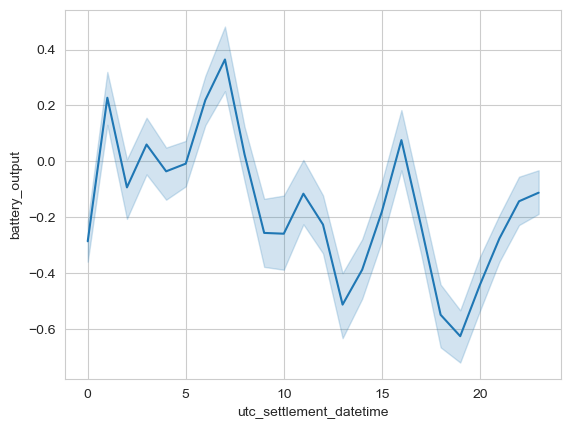

In [154]:
g = train
sns.lineplot(x=train[date].dt.hour, y=target, data=g);

# Pipeline

In [155]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes]

num_pp = Pipeline([
    ('dataselect', DataSelect(num))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(cat))
    , ('encoder', OneHotEncoder(sparse_output=False))
])

pipe = FeatureUnion([
    ('num', num_pp)
    , ('cat', cat_pp)
])

pipe.fit(train)
train_pre = pipe.transform(train)
# test_pre = pipe.transform(test)

# Submission

In [156]:
samp = pd.read_csv('/kaggle/input/eso-battery-forecasting/test_data.csv')

In [158]:
pred = pd.to_datetime(samp['UTC_Settlement_DateTime']).dt.hour.map(train.groupby(train[date].dt.hour)[target].mean())

In [159]:
pd.DataFrame({
    'id': samp['id']
    , 'battery_output': pred
}).to_csv('submission.csv', index=False)